# Predicting StarCraft II Win Probability - Notebook 2
By: [**Jared Lloyd**](https://github.com/jared-a-lloyd/sc2-modeling)

__[Brainstation](https://brainstation.io/)__ Capstone Project

---

<center><i><b><a style="color:darkviolet;font-size:18px">Are there inherent biases at game which would favor one player over the other from the outset?</a></b></i></center>

# Metadata Analysis and Modeling

In this Notebook we will be focusing on visually exploring and then modeling the Metadata of the two datasets we have extracted in Notebook 1.

As a reminder Metadata are the information that are collected about a game, not dealing with specific events within the game. This is the information that, for example, a viewer might be aware of before watching a replay of a match. The Metadata extracted in Notebook 1 contains:
* Game Length
* Game Map
* Game Mode
* Game Speed
* Game Type
* Game Winner
* Players' MMRs
* Players' Races

## Table of Contents
1. [Data Analysis](#section-1)
    1. [Wins per Race](#section-1-1)
    2. [Players per Pseudo-League](#section-1-2)
2. [Metadata Modeling](#section-2)
    1. [Data Wrangling](#section-2-1)
    2. [Modeling](#section-2-2)
3. [Conclusion](#section-3)

---

#### Package imports and settings
Notes:
* To deal with the size of the dataframes in this Notebook, the `pandas` max_rows and max_columns settings are set to 200. If editing any code please use `.head()` or some other limit when displaying dataframes.

In [60]:
# initial imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sc2reader
import re
import random
from datetime import datetime
import json
from scripts.classes import ReplayInfo
import time
import math
import multiprocessing as mp
import joblib

# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

# import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# import random forest
from sklearn.ensemble import RandomForestClassifier

# import KNN
from sklearn.neighbors import KNeighborsClassifier

# import grid_search
from sklearn.model_selection import GridSearchCV

# import warnings
import warnings

# import tqdm for progress bars
from tqdm import tqdm

# import partial for specifying functions for apply and multiprocessing
from functools import partial

# import IPython display
from IPython.display import display
# required for %%writefile code to update after changes
%load_ext autoreload 

#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style do not need to set
# each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 16 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 16
# set figure size
mpl.rcParams['figure.figsize'] = (18, 8)
# set grid on
mpl.rcParams['axes.grid'] = True
# set grid linestyle
mpl.rcParams['grid.linestyle'] = '--'
# set axis labels fontsize
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

#### Pandas options
# these are set to allow better exploration of the large dataframes in this 
# notebook
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1 - Data Analysis <a name="section-1"></a>

We will start by loading in the `filter_replays` function that was created in Notebook 1. This function will be used to clean the Metadata so that it can be used for modeling. In this Notebook we will be focusing getting the best quality model for Metadata from the data, so we will be using more stringent filtering on Metadata than in Notebook 3.

We can then load in the Metadata `csv` files that were created in Notebook 1, one for the SpawningTool dataset and one for Blizzard.

In [61]:
from scripts.filter_replays import filter_replays
%autoreload

In [62]:
# get the metadata dfs
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')
blizzard_df = pd.read_csv('data/blizzard_replays.csv')

# display the first few rows of the dataframes
print('<<<<SpawningTool>>>>')
display(spawningtool_df.head())
print('-'*80)
print('<<<<Blizzard>>>>')
display(blizzard_df.head())

<<<<SpawningTool>>>>


,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/SpawningTool/Other/page1/2-liberator-tank...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Protoss,-36400.0,NaN,402,1v1,Normal,1,2021-10-07 09:25:12,16.0,False,us,4,0,9384fda8c370ea7d130ac20244f7d0fda9a9b834004445...
1,data/SpawningTool/Other/page1/2-liberators-1-t...,abb20e9c587f5f6ce279a6aa8c7e9be2897607abb00434...,Terran,Zerg,-36400.0,NaN,371,1v1,Normal,1,2021-10-07 10:48:04,16.0,False,us,4,0,f9864054498acf297aacf2be80896ba131716a341983de...
2,data/SpawningTool/Other/page1/2000-atmospheres...,c2bcc137d9ce43fbf9a5ddd04f5167892c779c29616de9...,Zerg,Zerg,4022.0,3502.0,371,1v1,Faster,1,2021-10-09 14:16:39,16.0,True,eu,6,6,178a82fa5045e82a3920688274d7a524595f0ef6dc91ae...
3,data/SpawningTool/Other/page1/2021-09-05-zserr...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,NaN,NaN,1803,1v1,Faster,1,2021-09-02 18:50:40,16.0,False,eu,7,6,99ba80721116d18f965c141581baa878abf02526f48bc6...
4,data/SpawningTool/Other/page1/2021-10-01-zvaev...,e83bd9ddb33fcdc21a801f9bd598ed081f8ca60f810522...,Zerg,Protoss,3615.0,3567.0,502,1v1,Faster,1,2021-10-02 01:39:24,16.0,True,us,5,5,b9e96a1dabcc0de0cfd89e8f0d02b5b8e064ec3f3c07c1...


--------------------------------------------------------------------------------
<<<<Blizzard>>>>


,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash
0,data/Blizzard/set_1/0000e057beefc9b1e9da959ed9...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,2017-08-08 16:12:04,16.0,True,eu,6,6,9706f355243444e1666cd19a3a6cc1a315957e885f2ded...
1,data/Blizzard/set_1/0002b71a92623234bf67fac85e...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,2017-08-08 12:59:01,16.0,True,eu,5,5,e60e9fcdde514415eb2466ceab3c7d23af2b4549d74e89...
2,data/Blizzard/set_1/0002c4f2d94ba7aaf2f71b9d8c...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,2017-08-09 12:10:13,16.0,True,eu,5,0,82f4f6bf5d2c0af9b5a8f5c0c9606a0dc6819b09ae9a7a...
3,data/Blizzard/set_1/000309f32db5b1e65312208cca...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,2017-08-09 07:11:39,16.0,True,cn,3,3,2cc2384ffd09b3f6a63aa4fd2223db082dad6917c0f3b6...
4,data/Blizzard/set_1/000484de77e46af60af75a20b8...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,2017-08-09 14:47:02,16.0,True,us,5,5,537f1b82a364599638da021fabb2c9d975c94ca2f59eb7...


In [63]:
# clean the dataframes
print('Cleaning dataframes...')
print('<<<<SpawningTool>>>>')
spawningtool_df = filter_replays(spawningtool_df)
print('-'*20)
print('Length of SpawningTool dataframe after cleaning:', spawningtool_df.shape[0])
print('-'*80)
print('<<<<Blizzard>>>>')
blizzard_df = filter_replays(blizzard_df)
print('-'*20)
print('Length of Blizzard dataframe after cleaning:', blizzard_df.shape[0])


Cleaning dataframes...
<<<<SpawningTool>>>>
Length of dataframe before filtering: 36812
Game Length: 2996 replays were filtered
Player MMR: 24688 replays were filtered
Player Race: 125 replays were filtered
Region: 0 replays were filtered
Check_1v1: 2799 replays were filtered
Check_fps: 0 replays were filtered
Check_is_ladder: 0 replays were filtered
Check_game_speed: 0 replays were filtered
--------------------
Length of SpawningTool dataframe after cleaning: 6204
--------------------------------------------------------------------------------
<<<<Blizzard>>>>
Length of dataframe before filtering: 1203339
Game Length: 235673 replays were filtered
Player MMR: 27973 replays were filtered
Player Race: 52406 replays were filtered
Region: 0 replays were filtered
Check_1v1: 0 replays were filtered
Check_fps: 0 replays were filtered
Check_is_ladder: 0 replays were filtered
Check_game_speed: 0 replays were filtered
--------------------
Length of Blizzard dataframe after cleaning: 887287


We now have two clean dataframes of data. As can be seen above, the SpawningTool dataset is significantly reduced. This is mostly due to the MMR requirement of the filter which removes all games where players have an MMR below 2,000 or above 8,000, which also removes NaN values (for further discussion on MMR requirements see Notebook 1, Section 1.2). This dataset will mostly be included for the purpose of testing the Metadata model.

Data exploration in this Notebook is primarily performed on the Blizzard Metadata with the goal of developing a model predictive of the game winner. It will be useful to understand if there are any imbalances in the game, suggesting that a certain race is favoured on a particular map, or in longer or shorter games, or even at certain player skill levels (MMR).

### 1.1 - Wins per Race <a name="section-1-1"></a>

First we will establish what races win most for different player skill levels.

In [64]:
# function to add a column to the dataframe containing the winner race
def winning_race(row):
    """
    Helper function meant to be applied row-wise to a dataframe
    Creates a new column in the dataframe indicating the winner race
    """
    if row['game_winner'] == 1:
        return row['player1_race']
    else:
        return row['player2_race']


blizzard_df['winning_race'] = blizzard_df.apply(
    lambda row: winning_race(row), 
    axis=1
    )

blizzard_df.head()

,filename,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,filehash,winning_race
0,data/Blizzard/set_1/0000e057beefc9b1e9da959ed9...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,1v1,Faster,2,2017-08-08 16:12:04,16.0,True,eu,6,6,9706f355243444e1666cd19a3a6cc1a315957e885f2ded...,Zerg
1,data/Blizzard/set_1/0002b71a92623234bf67fac85e...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1v1,Faster,1,2017-08-08 12:59:01,16.0,True,eu,5,5,e60e9fcdde514415eb2466ceab3c7d23af2b4549d74e89...,Terran
2,data/Blizzard/set_1/0002c4f2d94ba7aaf2f71b9d8c...,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,1v1,Faster,2,2017-08-09 12:10:13,16.0,True,eu,5,0,82f4f6bf5d2c0af9b5a8f5c0c9606a0dc6819b09ae9a7a...,Zerg
3,data/Blizzard/set_1/000309f32db5b1e65312208cca...,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1v1,Faster,1,2017-08-09 07:11:39,16.0,True,cn,3,3,2cc2384ffd09b3f6a63aa4fd2223db082dad6917c0f3b6...,Zerg
4,data/Blizzard/set_1/000484de77e46af60af75a20b8...,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1v1,Faster,1,2017-08-09 14:47:02,16.0,True,us,5,5,537f1b82a364599638da021fabb2c9d975c94ca2f59eb7...,Zerg


In [65]:
# get the max mmr 
blizzard_df[['player1_mmr', 'player2_mmr']].max()

player1_mmr    6984
player2_mmr    7271
dtype: int64

<Figure size 1296x576 with 0 Axes>

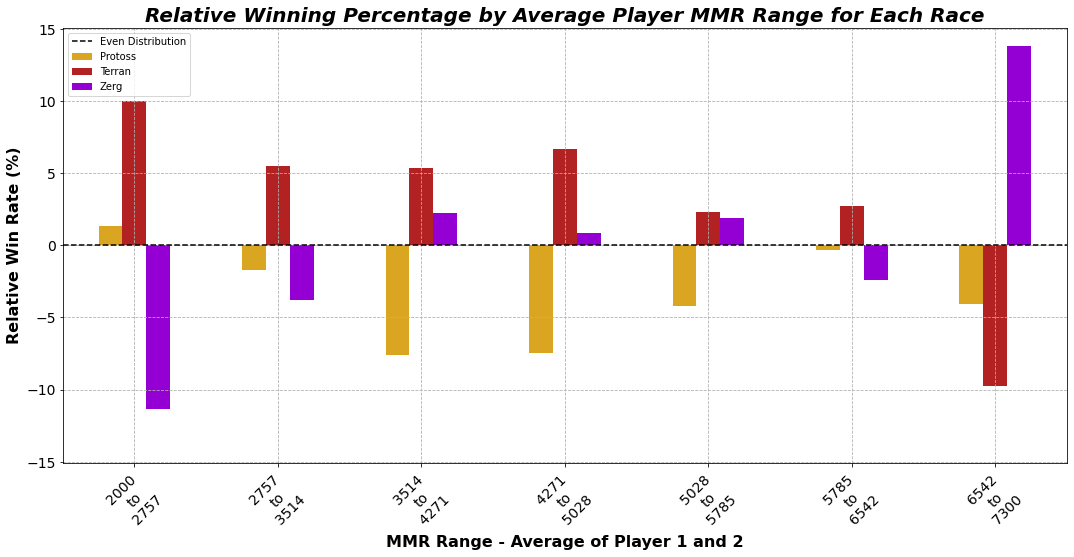

In [66]:
# create bins by which to group MMR
bins = np.linspace(2000, 7300, 8, dtype=int)

# add average mmr column
blizzard_df['average_mmr'] = blizzard_df[
    ['player1_mmr', 'player2_mmr']
    ].mean(axis=1)

blizzard_df['MMR_bins'] = pd.cut(blizzard_df['average_mmr'], bins)

# group by df_bins
grouped_df = blizzard_df.groupby('MMR_bins')[
    'winning_race'].value_counts().unstack()

# plot 
plt.figure()
grouped_df.div(
    grouped_df.sum(axis=1), axis=0
).multiply(100).sub(1/3*100).plot(
    kind='bar', 
    rot=45, 
    color=COLOR_DICT
)
# plot dotted line for 1/3
plt.axhline(y=0, color='k', linestyle='--', label='Even Distribution')
plt.ylabel('Relative Win Rate (%)')
plt.xlabel('MMR Range - Average of Player 1 and 2')
plt.title(
    'Relative Winning Percentage by Average Player MMR Range for Each Race',
    style='italic'
    )
# set ylims to be symmetric around 0
max_y = abs(max(plt.gca().get_ylim(), key=abs))
plt.gca().set_ylim(ymin=-max_y, ymax=max_y)

# change x labels to something more readable
x_labels = [f'{int(x.left)} \nto\n {int(x.right)}' for x in grouped_df.index]
plt.gca().set_xticklabels(x_labels, ha='center')
plt.legend()
plt.show()

The above bar chart shows the distribution for different divisions amongst player MMR. MMR for a game is calculated by taking the average MMR of the two players, and seven divisions are used to categorize the MMRs. 

If win-rate were equal between the races, we would not see a bar for any of the races, values above the bar indicate that the race is over-represented in Win Percentage, and vice versa if under.

Seven divisions are used because there are seven different levels into which players are divided in the game (called leagues): Bronze, Silver, Gold, Platinum, Diamond, Master, Grand Master. The divisions shown above do not and could not exactly correlate with the leagues as they differ from region to region and between seasons.


#### Pesudo-Leagues
To simplify the visualization of the data, divisions will be named according to the above described League scheme. We will refer to these as the "Pseudo-Leagues", since they are not representative of the actual leagues of the players.

In [67]:
# create a df with the count of players of each race for each MMR group
# get player 1 races
players_race_df = blizzard_df.groupby('MMR_bins')[
    'player1_race'].value_counts().unstack()
# add player 2 races
players_race_df += blizzard_df.groupby('MMR_bins')[
    'player2_race'].value_counts().unstack()

# define the league list
league_list = [
    'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master', 'Grand Master'
]

players_race_df.index = league_list
players_race_df

player1_race,Protoss,Terran,Zerg
Bronze,34991,45383,21826
Silver,195429,239642,177259
Gold,171776,257803,245495
Platinum,70285,111154,99939
Diamond,24220,31186,31078
Master,5593,5956,5279
Grand Master,85,75,120


This new dataframe will allow us to investigate the proportion of races represented in each bin. It will also allow a more informative investigation of the win rates for each race within each bin.

### 1.2 Player per Pseudo-League <a name="section-1-2"></a>

First we will investigate the total players in each Pseudo-League.

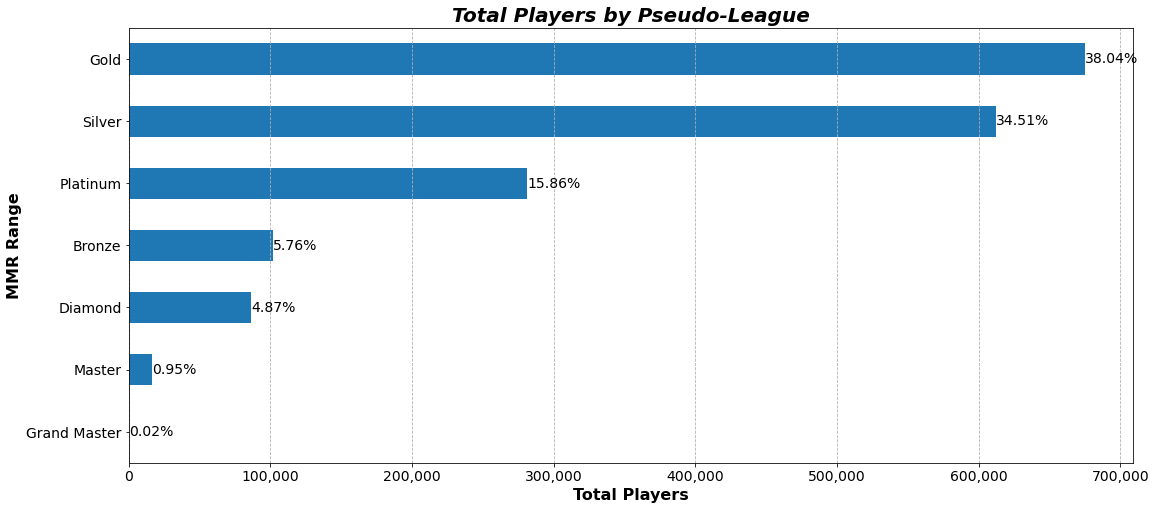

In [68]:
plt.figure()
# get total for each row and plot
# players_race_df.sum(axis=1).sort_values().div(
#     players_race_df.sum().sum()/100
# ).round(2).plot(kind='barh')
players_race_df.sum(axis=1).sort_values().plot(kind='barh')
plt.ylabel('MMR Range')
plt.xlabel('Total Players')
plt.title('Total Players by Pseudo-League', style='italic')
# format x tick labels with thousand separators
plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
# add annotation of percentages
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_width()/players_race_df.sum().sum()*100:.2f}%',
        (p.get_width() + 0.1, p.get_y() + p.get_height() / 2),
        ha='left',
        va='center',
        fontsize=14
    )
plt.grid(False)
plt.grid(axis='x')
plt.show()

<Figure size 1296x576 with 0 Axes>

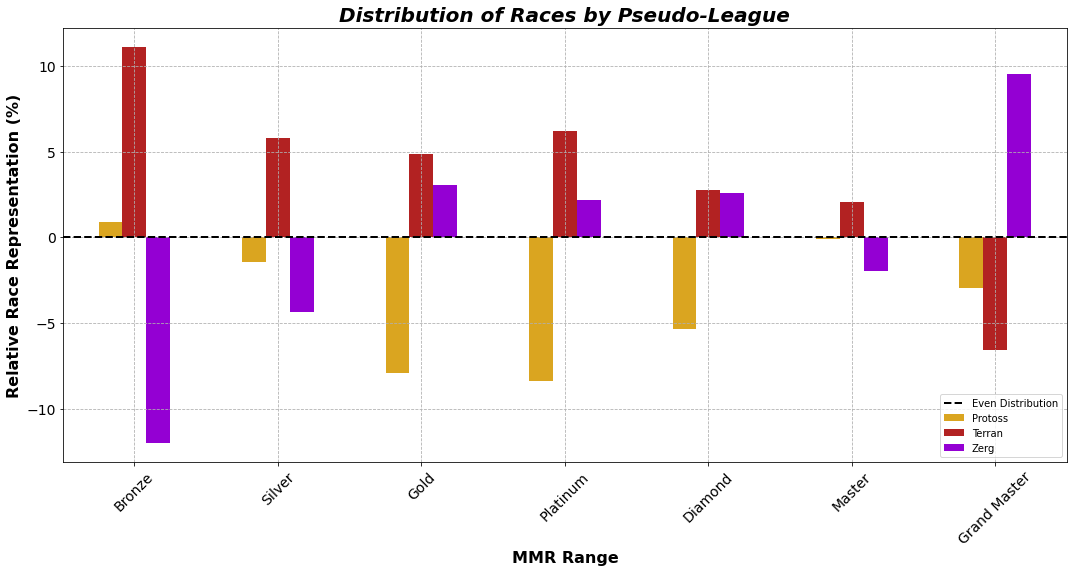

In [69]:
# plot distribution of players within each bin
plt.figure()
# calculate the proportion of players of each race in each bin relative to 33.3%
# divide each row by its sum, multiply by 100 for pct and subtract 33.3%
players_race_df.div(
    players_race_df.sum(axis=1).values, axis=0
).multiply(100).sub(1/3*100).plot(
    kind='bar',
    rot=45,
    color=COLOR_DICT
)
# plot the line showing even distribution
plt.axhline(
    y=0, 
    color='k', 
    linestyle='--', 
    linewidth=2, 
    label='Even Distribution'
)
plt.title('Distribution of Races by Pseudo-League', style='italic')
plt.xlabel('MMR Range')
plt.ylabel('Relative Race Representation (%)')
plt.legend()
plt.show()

It should be noted that due to the incredibly small amount of Grand Master players (0.016%) and even Master players, it is difficult to make any meaningful conclusions about the win rates of the different races at these levels. The discussion below deals with player sentiment in interpreting the above two charts.

The *Distribution of Races by Pseudo-League* chart shows a very similar trend to *Relative Winning Percentage by Average Player MMR Range for Each Race* before it. It may be worth investigating a normalized win rate for each race by calculating the number of victories proportional to the number of players for each Pseudo-League.

In the lower leagues <a style="color:firebrick"><b>Terran</b></a> is over-represented. This fraction decreases as MMR increases, finally flipping to under-representation in the highest bin. This has lead some players to believe that Terran is the hardest race to play. It is postulated by some in the __[community](https://us.forums.blizzard.com/en/sc2/t/why-terran-is-overpopulated-in-lower-leagues/19147)__ that this is because it is the most familiar race (they are human), and it is the first race new players experience in the Campaign mode - where a player plays through a story-line against computer controlled opponents instead of competitively against other humans.

<a style="color:goldenrod"><b>Protoss</b></a> is under-represented in most of the Pseudo-Leagues. This could be a peculiarity of the dataset as a whole because it is generally believed that Protoss is over-represented in the middle leagues.

<a style="color:darkviolet"><b>Zerg</b></a> is over-represented in the highest bin, and is the most under-represented in the lowest bin. Zerg has the most unconventional play style (quite dissimilar to the other two races), and this could contribute to low new player adoption. However, in the middle leagues it recovers when players have gotten used to it. The spike in the Grand Master Pseudo-League is reasonable considering the last 5 annual World Championships were won by Zerg.

To confirm that the data is representative, we have also extracted some information about the race distribution from __[RankedFTW](https://www.rankedftw.com/stats/races/1v1/#v=2&r=-2&l=-2)__ to compare.

In [70]:
# load the ranked for the win
rankedftw_df = pd.read_csv('data/rankedftw_race_distribution.csv', index_col=0)
# arrange columns in the same order as race_list
rankedftw_df = rankedftw_df[RACE_LIST]
# arrange index in the same order as players_race_df
# move to numerical index
rankedftw_df.reset_index(drop=True, inplace=True)
# sort in descending order
rankedftw_df.sort_index(ascending=False, inplace=True)
# reindex to the same index as players_race_df
rankedftw_df.index = players_race_df.index
rankedftw_df

,Protoss,Terran,Zerg
Bronze,1485,2287,1068
Silver,4515,5782,2600
Gold,3521,3932,2609
Platinum,3141,3594,2708
Diamond,3326,3776,3055
Master,656,535,380
Grand Master,137,140,91


<Figure size 1296x576 with 0 Axes>

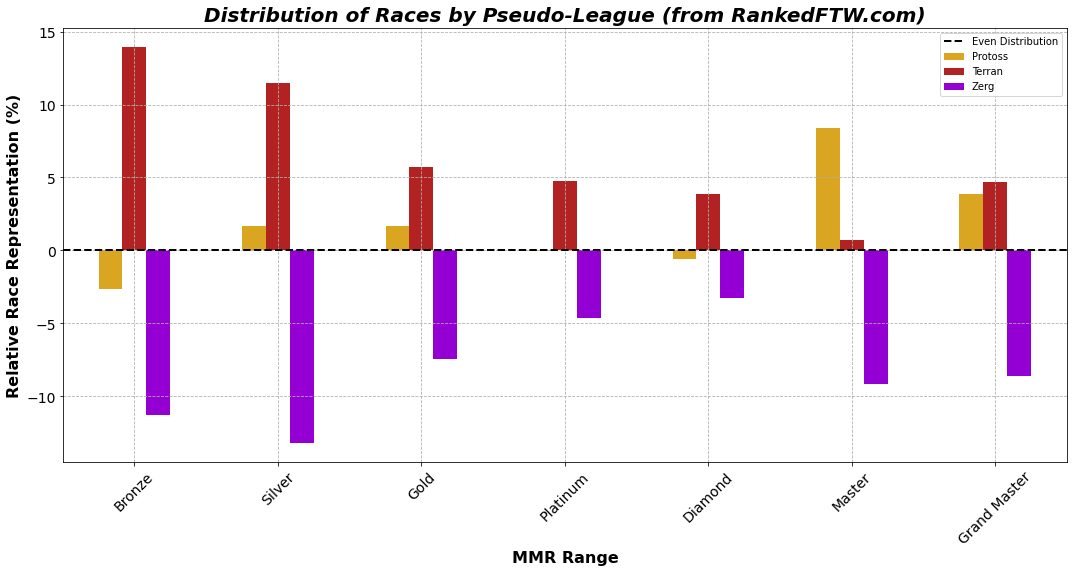

In [71]:
# plot distribution of players within each bin
plt.figure()
# calculate the proportion of players of each race in each bin relative to 33.3%
# divide each row by its sum, multiply by 100 for pct and subtract 33.3%
rankedftw_df.div(
    rankedftw_df.sum(axis=1).values, axis=0
).multiply(100).sub(1/3*100).plot(
    kind='bar',
    rot=45,
    color=COLOR_DICT
)
# plot the line showing even distribution
plt.axhline(
    y=0, 
    color='k', 
    linestyle='--', 
    linewidth=2, 
    label='Even Distribution'
)
plt.title('Distribution of Races by Pseudo-League (from RankedFTW.com)', style='italic')
plt.xlabel('MMR Range')
plt.ylabel('Relative Race Representation (%)')
plt.legend()
plt.show()

Comparing the RankedFTW distribution to Blizzard dataset shows that there are definite differences in composition by race for the leagues. This could be attributed to either different binning of the leagues vs the Pseudo-Leagues, or to changes in the game since the Blizzard data was produced.

In [72]:
# plot a histogram of blizzard_df timestamps
center_date = pd.to_datetime(blizzard_df['timestamp']).mode()[0].date()

print('The mode of Blizzard dates is', center_date)

The mode of Blizzard dates is 2017-07-28


Blizzard data is approximately four years old, while the data from RankedFTW is current. This could explain some differences in the distributions of the races, as game design and balance have changed significantly in this time period. It may be worth collecting more recent data than the Blizzard dataset for future modeling attempts.


---

## Section 2 - Metadata Modeling <a name="section-2"></a>

### 2.1 Data Wrangling <a name="section-2-1"></a>
To prepare for Metadata modeling we will first ensure that data are all in the correct format. Categorical variables, such as player race, will need to be converted to dummy variables. We will create a column for each categorical class with a 1 or 0 indicating which one of the classes is chosen.

First we will investigate what data is available, and what if any is missing (NaN values).

In [73]:
# get the count of unique values in each column
print('Unique values in each column:')
blizzard_df.nunique()

Unique values in each column:


filename                  887287
map                            9
player1_race                   3
player2_race                   3
player1_mmr                 4451
player2_mmr                 4923
game_length                 2400
game_type                      1
game_speed                     1
game_winner                    3
timestamp                 753743
fps                            1
is_ladder                      1
region                         4
player1_highest_league         8
player2_highest_league         8
filehash                  887287
winning_race                   3
average_mmr                 8983
MMR_bins                       7
dtype: int64

Here we will:
* Convert maphash to an index value.
* Convert categorical columns to dummy variables.
* Convert game_winner to a binary variable stating if player 1 won or not.
* Keep only informative columns:
    * `game_winner` - The target for the model.
    * `map` - It is believed in the community that the map is important for the game outcome.
    * `game_length` - This could be impactful on outcome, but it will have to be transformed in some way. Short games could favour one race, and long games another.
    * `player1_race`
    * `player2_race`
    * `player1_mmr`
    * `player2_mmr`
* Create features as necessary:
    * We will use player1 and 2 mmr to calculate player1 mmr advantage (i.e., player1 mmr - player2 mmr)

Information that will be discarded is:
* `filename` - Not meaningful.
* `game_type` - Not expected to be predictive of the game outcome as there is only one class.
* `fps` - Not meaningful, and there is only a single class value.
* `game_speed` - Not meaningful, and there is only a single class value.
* `is_ladder` - Not meaningful, and there is only a single class value.
* `player<>_highest_league` - Contains the same information as player MMR.
* `filehash` - Not meaningful.
* `winning_race` - This variable is not useful as a predictor as it already includes information about the winning player.
* `region` - The region would not be expected to directly impact the game outcome. This variable could be useful in clustering for future modeling attempts.
* `MMR_bins` - Information is similar to player MMR, but this variable could be used for clustering similar to `region`.
* `timestamp` - It is not expected that the date would be predictive of the outcome.
* `average_mmr` - This is already included in the player MMR variables.
* We will also drop any games where the outcome is a draw, as we are only interested in either Player 1 or Player 2 victories.



In [74]:
# create a list of columns to drop
drop_columns = [
    'filename',
    'game_type',
    'fps',
    'game_speed',
    'is_ladder',
    'player1_highest_league',
    'player2_highest_league',
    'filehash',
    'winning_race',
    'region',
    'MMR_bins',
    'timestamp',
    'average_mmr'
]

# create a mask of where game_winner is not = 0
mask = blizzard_df['game_winner'] != 0

# create modeling df using copy to avoid changing original df
modeling_df = blizzard_df.loc[mask].drop(columns=drop_columns).copy()

print('The shape of the original Blizzard dataframe is', blizzard_df.shape)
print('The shape of the modeling dataframe is', modeling_df.shape)
rows_dropped = blizzard_df.shape[0] - modeling_df.shape[0]
columns_dropped = blizzard_df.shape[1] - modeling_df.shape[1]
print(f'{rows_dropped} columns were dropped and {columns_dropped} rows were dropped.')

The shape of the original Blizzard dataframe is (887287, 20)
The shape of the modeling dataframe is (885304, 7)
1983 columns were dropped and 13 rows were dropped.


In [75]:
# inspect the dataframe
display(modeling_df.info())
print(f'There are {modeling_df.isna().sum().sum()} missing values.')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885304 entries, 0 to 1203338
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   map           885304 non-null  object
 1   player1_race  885304 non-null  object
 2   player2_race  885304 non-null  object
 3   player1_mmr   885304 non-null  int64 
 4   player2_mmr   885304 non-null  int64 
 5   game_length   885304 non-null  int64 
 6   game_winner   885304 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 54.0+ MB


None

There are 0 missing values.


In [76]:
modeling_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
map,885304,9,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,151523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player1_race,885304,3,Terran,347386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player2_race,885304,3,Terran,342111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player1_mmr,885304.0,NaN,NaN,NaN,3756.705642,728.010242,2000.0,3244.0,3674.0,4177.0,6984.0
player2_mmr,885304.0,NaN,NaN,NaN,3758.202105,731.786136,2000.0,3245.0,3673.0,4176.0,7271.0
game_length,885304.0,NaN,NaN,NaN,784.052037,351.94992,300.0,526.0,724.0,961.0,2700.0
game_winner,885304.0,NaN,NaN,NaN,1.50028,0.5,1.0,1.0,2.0,2.0,2.0


There are a few columns where the data needs to be transformed:
* `map` - We will convert the map to a numerical value for readability before dummy conversion.
* `player<>_race` - This will be converted to dummy variables
* `player<>_mmr` - We will convert these to a single feature that measures the difference between Player 1 and 2
* `game_winner` - We will rename this column to `winner` for simplicity. We will map `1` to Player 1 victory, and `0` to Player 2 victory.

In [77]:
# convert map to a more readable format, i.e map_1 to map_9
# maphash_converter = {}
# for i, maphash in enumerate(modeling_df['map'].unique()):
#     maphash_converter[maphash] = str(i+1)
# modeling_df['map'] = modeling_df['map'].map(maphash_converter)

# rename game_winner to winner
modeling_df.rename(columns={'game_winner': 'winner'}, inplace=True)

# map the player 1 win to 1 and player 2 win to 0
modeling_df['winner'] = modeling_df['winner'].map({1: 1, 2: 0})

modeling_df.head()

,map,player1_race,player2_race,player1_mmr,player2_mmr,game_length,winner
0,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Protoss,Zerg,5402,5564,932,0
1,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Terran,Terran,3882,3951,324,1
2,be0af789b8cef0379fd32602b5730096bb0b0138fe7aba...,Terran,Zerg,4088,3365,667,0
3,89b9c8252bd9bb72175be78d66280d68ef2a525143db27...,Zerg,Terran,3234,3063,775,1
4,37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e836...,Zerg,Zerg,4254,4121,537,1


#### Create dummy variables for categorical variables
Initially we will not drop the first dummy column. Often it is a good idea to drop one of the dummy columns to prevent collinearity issues when modeling. However, we will attempt modeling with regularization to try and counteract this.

In [78]:
# set up a list of columns we want to convert to dummy variables
dummy_columns = [
    'map',
    'player1_race',
    'player2_race'
]

# set up a list of prefixes we will use for each dummy
prefix_list = [
    'map',
    'p1',
    'p2'
]

# convert to dummies
modeling_df = pd.get_dummies(
    modeling_df,
    prefix=prefix_list,
    columns=dummy_columns,
    drop_first=False
)
modeling_df.head()

,player1_mmr,player2_mmr,game_length,winner,map_0be2c3967190fc31418b5e1b09f530f9e2d489201b1111b5e3ccbc5e6784056b,map_37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e8365c71e98c5e8a43e3cc,map_5160a062b890a6f2487deedc1f4acd8d1eb9324b6fe8a7cf384743bfd80a8b94,map_760f86485046d5f6641011dcea20b2cd6c0214d9029006d0698c4e6dc9ffcf5b,map_89b9c8252bd9bb72175be78d66280d68ef2a525143db27049d35638d3b00e239,map_8e8a27bc43f7c310705c16e4a564f64f228bf17085aaf9e16b67779c74dce2ec,map_be0af789b8cef0379fd32602b5730096bb0b0138fe7aba0ae1a107b143b101f8,map_c3df4517b78fb0c6042f76667341403faf9b0fc479548f6a440f69bb35c2fd34,map_fd8898dbe586fa967760980debcad0ce20610fb447cd0697c109d4ebf7d1d5cf,p1_Protoss,p1_Terran,p1_Zerg,p2_Protoss,p2_Terran,p2_Zerg
0,5402,5564,932,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,3882,3951,324,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,4088,3365,667,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,3234,3063,775,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
4,4254,4121,537,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


#### Create a feature that measures the difference between Player 1 and 2 MMR
Here we will create a single column measuring the difference between Player 1 and 2 MMR. We will then drop Player 1 and 2 MMR columns.

In [79]:
# calculate the new feature column
modeling_df['mmr_advantage'] = modeling_df['player1_mmr'] - modeling_df['player2_mmr']

# drop the original mmr columns
modeling_df.drop(columns=['player1_mmr', 'player2_mmr'], inplace=True)

modeling_df.head()


,game_length,winner,map_0be2c3967190fc31418b5e1b09f530f9e2d489201b1111b5e3ccbc5e6784056b,map_37bd8ab1409dddf9ee2d2630cabddec5c6ffeab113e8365c71e98c5e8a43e3cc,map_5160a062b890a6f2487deedc1f4acd8d1eb9324b6fe8a7cf384743bfd80a8b94,map_760f86485046d5f6641011dcea20b2cd6c0214d9029006d0698c4e6dc9ffcf5b,map_89b9c8252bd9bb72175be78d66280d68ef2a525143db27049d35638d3b00e239,map_8e8a27bc43f7c310705c16e4a564f64f228bf17085aaf9e16b67779c74dce2ec,map_be0af789b8cef0379fd32602b5730096bb0b0138fe7aba0ae1a107b143b101f8,map_c3df4517b78fb0c6042f76667341403faf9b0fc479548f6a440f69bb35c2fd34,map_fd8898dbe586fa967760980debcad0ce20610fb447cd0697c109d4ebf7d1d5cf,p1_Protoss,p1_Terran,p1_Zerg,p2_Protoss,p2_Terran,p2_Zerg,mmr_advantage
0,932,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,-162
1,324,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,-69
2,667,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,723
3,775,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,171
4,537,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,133


In [80]:
print('The shape of the modeling dataframe is', modeling_df.shape)

The shape of the modeling dataframe is (885304, 18)


Before we begin modeling, we will modify the map column titles to be less verbose. Instead of a maphash, we will assign them an arbitrary integer value. In either case, the number is just an index, but integers make the dataframe display more readable.

In [81]:
# rename all columns starting with map
# create a list of unique column names starting with map_
map_columns = [
    col for col in modeling_df.columns if col.startswith('map_')
]
# create a new name for every name in map_columns
new_map_columns = [
    'map_' + str(i) for i in range(len(map_columns))
]
# rename the columns
modeling_df.rename(columns=dict(zip(map_columns, new_map_columns)), inplace=True)

modeling_df.head()


,game_length,winner,map_0,map_1,map_2,map_3,map_4,map_5,map_6,map_7,map_8,p1_Protoss,p1_Terran,p1_Zerg,p2_Protoss,p2_Terran,p2_Zerg,mmr_advantage
0,932,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,-162
1,324,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,-69
2,667,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,723
3,775,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,171
4,537,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,133


### 2.2 Modeling <a name="section-2-2"></a>
Data will be split into a test and a train set. There is no need for a separate validation set because we will use a `GridSearchCV` to find the best parameters for the model, and to test several different types of categorical models. `GridSearchCV` includes cross validation that will automatically split the data into training and validation sets. 

The models we will be testing are:
* `LogisticRegression` (LR) - A standard linear binary classification model.
* `RandomForestClassifier` (RF) - An ensemble of decision trees.
* `KNeighborsClassifier` (KNN) - A classifier that classifies samples by measuring the distance to the k nearest neighbors.

It would not be practical to perform SVM (Support Vector Machine) at this point, as the dataset is too large for efficient processing on consumer hardware.

We will create a pipeline that will include the following steps:
* `scaling` - This will scale the data to a common range using either `StandardScaler` or `MinMaxScaler`. `StandardScaler` makes the mean of the data 0 and the standard deviation of the data 1. `MinMaxScaler` scales the data to a range of 0 to 1.
* `reduce_dim` - Reducing dimensionality using PCA, or `None` if no dimensionality reduction is desired. PCA or Principal Component Analysis is a technique that can be used to reduce the dimensionality of the data. It measures the variance of the data and then selects dimensions that represent as much of the variance as possible. The keyword 'passthrough' is used for a case where no PCA is applied.
* `model` - This will be the model that will be used to predict the outcome.

We can then set up a grid of parameters to test for each model. For all models, a `random_state` will be set to 42 to ensure reproducibility.

**Logistic Regression:**
* `penalty` - The type of regularization to use. L1 and L2 are available, 
* `C` - The inverse of regularization strength. A larger value implies a smaller penalty.
* `solver` - The solver to use. `sag` and `saga` are preferred to `liblinear` for large datasets, so `liblinear` is excluded. **Note:** Errors will likely be produced while fitting the `GridSearchCV` because some solvers are only applicable to one of the two `penalty` options. This is expected behavior, but may be suppressed by using a context manager to suppress warnings.

**RF:**
* `n_estimators` - The number of trees in the forest.
* `max_depth` - The maximum depth of the tree (number of splits).
* `min_samples_leaf` - The minimum number of samples required to be at a leaf (end) node.

**KNN:**
* `n_neighbors` - The number of neighbors to consider.


In [22]:
# NOTE: This code will take at least 30 minutes to run
# create a list of estimators to use
estimator_list = [
    ('scaling', StandardScaler()),
    ('reduce_dim', PCA(n_components=2)),
    ('model', LogisticRegression())
]

# initialize the pipeline
pipeline = Pipeline(estimator_list)

# define a list of parameter dictionaries to use
param_grid = [

    # logistic regression
    {
        'scaling': [StandardScaler(), MinMaxScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': ['passthrough', 2, 3],
        'model': [LogisticRegression()],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['saga', 'newton-cg', 'lbfgs', 'sag'],
        'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'model__random_state': [42]
    },

    # random forest
    {
        'scaling': [StandardScaler(), MinMaxScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': ['passthrough', 2, 3],
        'model': [RandomForestClassifier()],
        'model__n_estimators': [10, 30, 50, 100],
        'model__max_depth': [2, 5, 7],
        'model__min_samples_leaf': [1, 2, 5],
        'model__random_state': [42]
    },

    # KNN
    {
        'scaling': [StandardScaler(), MinMaxScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': ['passthrough', 2, 3],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [1, 2, 3, 5, 10, 20, 50]
    }
]

# set up a grid search
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy', # use accuracy_score for classification
    cv=3, # the number of folds to use for cross-validation
    n_jobs=6, # the number of cores to use for parallelization
    verbose=50 # the verbosity level
)

# divide the data into X and y
X = modeling_df.drop(columns=['winner'])
y = modeling_df['winner']

# do a test train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# fit the grid search with suppressed warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)
    


In [23]:
# save the grid search object
joblib.dump(grid, 'models/Metadata_grid_search_maps.pkl')

In [24]:
# loaded from pickle to avoid needing to rerun the entire fit every time
grid = joblib.load('models/Metadata_grid_search_maps.pkl')

In [25]:
# store results in a dataframe
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.reset_index(drop=False, inplace=True)
results.set_index('rank_test_score', inplace=True)
results.head()

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__penalty,param_model__random_state,param_model__solver,param_reduce_dim,param_reduce_dim__n_components,param_scaling,param_model__max_depth,param_model__min_samples_leaf,param_model__n_estimators,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,,
1,502,48.862855,0.318183,1.656666,0.097378,"RandomForestClassifier(max_depth=7, random_sta...",NaN,NaN,42,NaN,PCA(n_components=3),3,StandardScaler(),7,1,100,NaN,"{'model': RandomForestClassifier(max_depth=7, ...",0.553619,0.549655,0.560244,0.554506,0.004368
2,592,3.276998,0.008484,10.942337,0.714532,KNeighborsClassifier(),NaN,NaN,NaN,NaN,PCA(),3,StandardScaler(),NaN,NaN,NaN,50,"{'model': KNeighborsClassifier(), 'model__n_ne...",0.538142,0.558935,0.557127,0.551401,0.009405
3,490,16.142335,0.131139,0.568666,0.021640,"RandomForestClassifier(max_depth=7, random_sta...",NaN,NaN,42,NaN,PCA(n_components=3),3,StandardScaler(),7,1,30,NaN,"{'model': RandomForestClassifier(max_depth=7, ...",0.548858,0.544178,0.553929,0.548988,0.003982
4,538,16.014671,0.177061,0.554329,0.041065,"RandomForestClassifier(max_depth=7, random_sta...",NaN,NaN,42,NaN,PCA(n_components=3),3,StandardScaler(),7,5,30,NaN,"{'model': RandomForestClassifier(max_depth=7, ...",0.558169,0.545207,0.542322,0.548566,0.006891
5,586,3.367999,0.037497,8.926667,0.339756,KNeighborsClassifier(),NaN,NaN,NaN,NaN,PCA(),3,StandardScaler(),NaN,NaN,NaN,20,"{'model': KNeighborsClassifier(), 'model__n_ne...",0.552552,0.544360,0.547143,0.548018,0.003401


In [26]:
# print the params for the best 10 models
for i in range(0, 10):
    print('Model rank',i+1)
    print('-'*20)

    # get the row containing the model
    this_model = results.loc[i+1]
    
    # get the score
    print(f'Mean Cross-Validation Score: {round(this_model["mean_test_score"]*100,2)}%')

    # print the params
    this_params = this_model['params']
    for key, value in this_params.items():
        if key == 'model':
            # only print the model name
            new_value = str(value).split('(')[0]
            print(f'{key}: {new_value}')
            
        else:
            print(f'{key}: {value}')
    print('-'*80)

Model rank 1
--------------------
Mean Cross-Validation Score: 55.45%
model: RandomForestClassifier
model__max_depth: 7
model__min_samples_leaf: 1
model__n_estimators: 100
model__random_state: 42
reduce_dim: PCA(n_components=3)
reduce_dim__n_components: 3
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 2
--------------------
Mean Cross-Validation Score: 55.14%
model: KNeighborsClassifier
model__n_neighbors: 50
reduce_dim: PCA()
reduce_dim__n_components: 3
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 3
--------------------
Mean Cross-Validation Score: 54.9%
model: RandomForestClassifier
model__max_depth: 7
model__min_samples_leaf: 1
model__n_estimators: 30
model__random_state: 42
reduce_dim: PCA(n_components=3)
reduce_dim__n_components: 3
scaling: StandardScaler()
--------------------------------------------------------------------------------
Mo

Of the top 10 models, 9 are Random Forest. This appears to be the best model type for our data. We can visualize this to make it clearer.

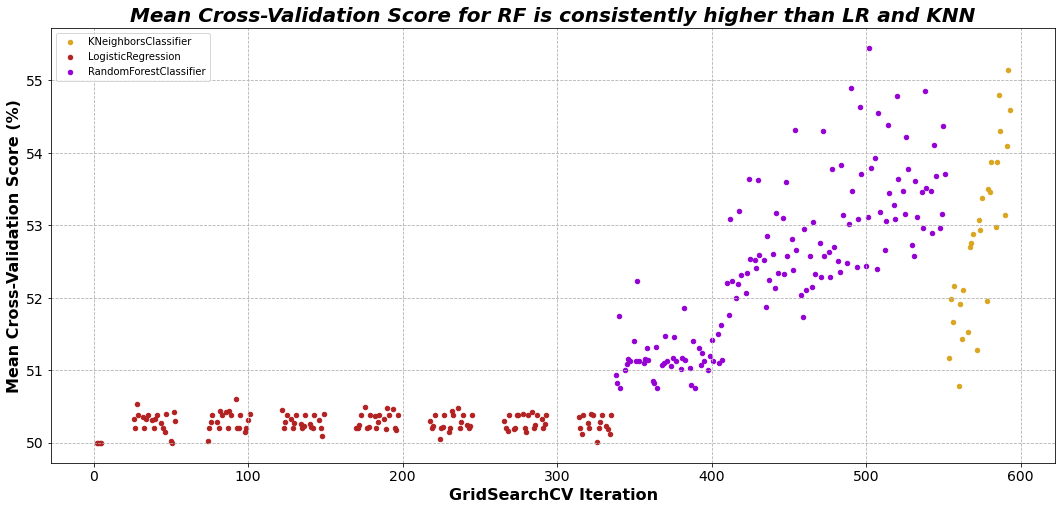

In [27]:
# create a new column with just the model name
results['model_name'] = results['param_model'].apply(lambda x: str(x).split('(')[0])

# plot results sorted by model name and mean test score
# set color based on model name

plotting_results = results.sort_values(by=['model_name', 'mean_test_score']).reset_index(drop=True)

plotting_results['mean_test_score'] = plotting_results['mean_test_score']*100

plt.figure()
for i, m_name in enumerate(plotting_results['model_name'].unique()):
    plotting_results.loc[plotting_results['model_name'] == m_name].plot(
        x='index',
        y='mean_test_score',
        kind='scatter',
        label=m_name,
        color=list(COLOR_DICT.values())[i],
        ax=plt.gca()
    )
plt.xlabel('GridSearchCV Iteration')
plt.ylabel('Mean Cross-Validation Score (%)')
plt.title(
    'Mean Cross-Validation Score for RF is consistently higher than LR and KNN',style='italic'
)

plt.show()

We can now gather the model predictions on the test set and evaluate the overall performance of the model. We will select the best model from the grid search.

In [28]:
# function to calculate precision and recall for both players
def calculate_precision_recall(true_y, pred_y, print_results=True):
    """
    calculate_precision_recall
    Calculate the precision and recall for both players.

    Args:
        true_y (array): the true labels
        pred_y (array): the predicted labels
        print_results (bool): whether to print the results or not
    Returns:
        tuple: the precision and recall for both players
    """    

    # calculate precision and recall for player 1
    p1_precision = round(
        precision_score(
            true_y,
            pred_y,
            pos_label=1
        )*100,
        2
    )
    p1_recall = round(
        recall_score(
            true_y,
            pred_y,
            pos_label=1
        )*100,
        2
    )
    # calculate precision and recall for player 2
    p2_precision = round(
        precision_score(
            true_y,
            pred_y,
            pos_label=0
        )*100,
        2
    )
    p2_recall = round(
        recall_score(
            true_y,
            pred_y,
            pos_label=0
        )*100,
        2
    )

    if print_results:
        # print the results
        output = pd.DataFrame(
            {
                'Player 1': [p1_precision, p1_recall],
                'Player 2': [p2_precision, p2_recall]
            },
            index=['Precision (%)', 'Recall (%)']
        )

        print('Precision and Recall for both players')
        display(output.style.format(precision=2))
    
    return (p1_precision, p1_recall), (p2_precision, p2_recall)

In [29]:
# function to display the confusion matrix in a nice format
def display_confusion_matrix(
    y_true,
    y_pred,
    class_names,
    as_percentages=True,
):
    """
    display_confusion_matrix
    Display a confusion matrix created by the sklearn module as a formatted pandas dataframe with styled background and class labels.

    Args:
        y_true (array): the true labels
        y_pred (array): the predicted labels
        class_names (array): the names of the classes
        as_percentages (bool): whether to display the percentages or the counts
    Returns:
        None
    """    

    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true, y_pred)

    # create a pandas dataframe from the confusion matrix
    df_cm = pd.DataFrame(
        cm, 
        index=['True ' + v for v in class_names], 
        columns=['Pred ' + v for v in class_names]
    )

    title_string = 'Confusion Matrix'

    # convert to percentages if desired
    if as_percentages:
        # divide each cell by the sum of all cells times by 100 to percent
        df_cm = df_cm / df_cm.sum().sum() * 100
        # round the values to 2 decimal places
        df_cm = df_cm.round(2)
        # add a % sign to the column names
        df_cm.columns = ['% ' + c for c in df_cm.columns]
        # add a % sign to the row names
        df_cm.index = ['% ' + c for c in df_cm.index]
        # update the title string
        title_string = 'Confusion Matrix (Percentages)'

    print('-'*40)
    print(f'\t{title_string}')
    display(df_cm.style.background_gradient().format(precision=2))
    print('-'*40)

In [30]:
# predict X_test with the best model
y_pred = grid.predict(X_test)

# calculate the accuracy_score
acc_score = round(accuracy_score(y_test, y_pred)*100,2)

# calculate mean of y_test
blind_acc = round(np.mean(y_test)*100,2)
# invert if less than 0.5 because the guess would flip at this point
if blind_acc < 50:
    blind_acc = 100 - blind_acc

print(f'A blind guess would have an accuracy of {blind_acc}%')
print(f'The model has accuracy of {acc_score}% on the test set.')
_ = calculate_precision_recall(y_test, y_pred)
display_confusion_matrix(y_test, y_pred, ['Player2 Win', 'Player1 Win'])

A blind guess would have an accuracy of 50.16%
The model has accuracy of 54.54% on the test set.
Precision and Recall for both players


,Player 1,Player 2
Precision (%),54.37,54.71
Recall (%),54.65,54.43


----------------------------------------
	Confusion Matrix (Percentages)


,% Pred Player2 Win,% Pred Player1 Win
% True Player2 Win,27.30,22.86
% True Player1 Win,22.60,27.24


----------------------------------------


The best model improved the prediction on the test set by around 4%. This is a sign that it is not trivial to predict the outcome of the game at the game start, and will serve as the baseline against which we compare the RNN model prepared in Notebook 3.

#### Re-run model without the maps variables

Now that we have seen which estimator performed best, we will re-run without the maps variables to test the effect of maps on the predictive quality of the data. After that we will test by predicting `X_test` and by predicting the SpawningTool data and checking the accuracy.

In [31]:
# NOTE: This code will take at least 30 minutes to run
# drop all columns starting with map from modeling_df
drop_columns = [col for col in modeling_df if col.startswith('map')]
modeling_df.drop(columns=drop_columns, inplace=True)

# divide the data into X and y
X = modeling_df.drop(columns=['winner'])
y = modeling_df['winner']

# do a test train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# fit the same grid search with suppressed warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)
    

In [32]:
# save the grid search object
joblib.dump(grid, 'models/Metadata_grid_search_no_maps.pkl')

In [54]:
# loaded from pickle to avoid needing to rerun the entire fit every time
grid = joblib.load('models/Metadata_grid_search_no_maps.pkl')

In [55]:
# store results in a dataframe
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.reset_index(drop=False, inplace=True)
results.set_index('rank_test_score', inplace=True)

# print the params for the best 10 models
for i in range(0, 10):
    print('Model rank',i+1)
    print('-'*20)

    # get the row containing the model
    this_model = results.loc[i+1]
    
    # get the score
    print(f'Mean Cross-Validation Score: {round(this_model["mean_test_score"]*100,2)}%')

    # print the params
    this_params = this_model['params']
    for key, value in this_params.items():
        if key == 'model':
            # only print the model name
            new_value = str(value).split('(')[0]
            print(f'{key}: {new_value}')
            
        else:
            print(f'{key}: {value}')
    print('-'*80)

Model rank 1
--------------------
Mean Cross-Validation Score: 57.18%
model: KNeighborsClassifier
model__n_neighbors: 50
reduce_dim: PCA(n_components=3)
reduce_dim__n_components: 3
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 2
--------------------
Mean Cross-Validation Score: 57.06%
model: KNeighborsClassifier
model__n_neighbors: 50
reduce_dim: PCA(n_components=3)
reduce_dim__n_components: 2
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 3
--------------------
Mean Cross-Validation Score: 56.78%
model: RandomForestClassifier
model__max_depth: 7
model__min_samples_leaf: 1
model__n_estimators: 30
model__random_state: 42
reduce_dim: PCA(n_components=3)
reduce_dim__n_components: 3
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 4
--------------------
Mean Cross-Validation Score:

This time KNN is be the best model. We will confirm this by re-plotting the results of all `GridSearchCV` models from the last fit.

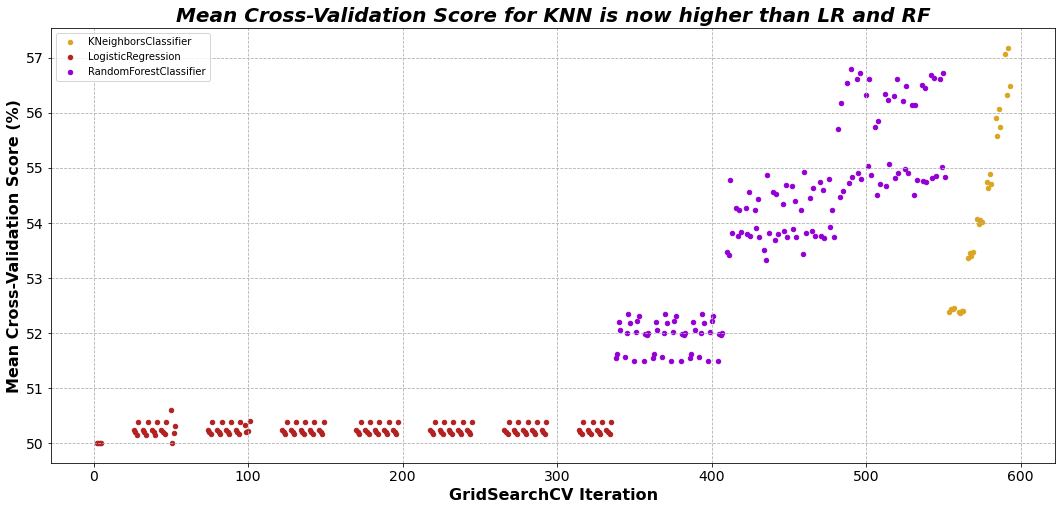

In [56]:
# create a new column with just the model name
results['model_name'] = results['param_model'].apply(lambda x: str(x).split('(')[0])

# plot results sorted by model name and mean test score
# set color based on model name

plotting_results = results.sort_values(by=['model_name', 'mean_test_score']).reset_index(drop=True)

plotting_results['mean_test_score'] = plotting_results['mean_test_score']*100

plt.figure()
for i, m_name in enumerate(plotting_results['model_name'].unique()):
    plotting_results.loc[plotting_results['model_name'] == m_name].plot(
        x='index',
        y='mean_test_score',
        kind='scatter',
        label=m_name,
        color=list(COLOR_DICT.values())[i],
        ax=plt.gca()
    )
plt.xlabel('GridSearchCV Iteration')
plt.ylabel('Mean Cross-Validation Score (%)')
plt.title(
    'Mean Cross-Validation Score for KNN is now higher than LR and RF',style='italic'
)

plt.show()

We will select KNN as the final model that will be used to predict the metadata model. Currently it seems that the accuracy of the KNN model is improving with each GridSearch iteration, implying that we are heading in the right direction, but that our variable (number of neighbors) is not yet high enough. We will run one final `GridSearchCV` on only the KNN model, with a much wider range of parameters, in order to find the best fit.

In [46]:
# NOTE: This code will take at least 40 minutes to run and may create memory issues
# create a list of estimators to use
estimator_list = [
    ('scaling', StandardScaler()),
    ('reduce_dim', PCA(n_components=2)),
    ('model', LogisticRegression())
]

# initialize the pipeline
pipeline = Pipeline(estimator_list)

# define a list of parameter dictionaries to use
param_grid = [
    # KNN
    {
        'scaling': [StandardScaler(), MinMaxScaler()],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': ['passthrough', 2, 3, 4, 5, 6, 10],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': np.linspace(100, 1000, 11, dtype=int),
    }
]

# set up a grid search
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy', # use accuracy_score for classification
    cv=5, # the number of folds to use for cross-validation
    n_jobs=6, # the number of cores to use for parallelization
    verbose=50 # the verbosity level
)

# divide the data into X and y
X = modeling_df.drop(columns=['winner'])
y = modeling_df['winner']

# do a test train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# fit the grid search with suppressed warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)

Fitting 5 folds for each of 154 candidates, totalling 770 fits


In [47]:
# save the grid search object
joblib.dump(grid, 'models/Metadata_grid_search_KNN.pkl')

['models/Metadata_grid_search_KNN.pkl']

In [57]:
# load the grid search object
grid = joblib.load('models/Metadata_grid_search_KNN.pkl')

In [58]:
# store results in a dataframe
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.reset_index(drop=False, inplace=True)
results.set_index('rank_test_score', inplace=True)

# print the params for the best 10 models
for i in range(0, 10):
    print('Model rank',i+1)
    print('-'*20)

    # get the row containing the model
    this_model = results.loc[i+1]
    
    # get the score
    print(f'Mean Cross-Validation Score: {round(this_model["mean_test_score"]*100,2)}%')

    # print the params
    this_params = this_model['params']
    for key, value in this_params.items():
        if key == 'model':
            # only print the model name
            new_value = str(value).split('(')[0]
            print(f'{key}: {new_value}')
            
        else:
            print(f'{key}: {value}')
    print('-'*80)

Model rank 1
--------------------
Mean Cross-Validation Score: 58.47%
model: KNeighborsClassifier
model__n_neighbors: 1000
reduce_dim: PCA(n_components=6)
reduce_dim__n_components: 6
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 2
--------------------
Mean Cross-Validation Score: 58.46%
model: KNeighborsClassifier
model__n_neighbors: 910
reduce_dim: PCA(n_components=6)
reduce_dim__n_components: 6
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 3
--------------------
Mean Cross-Validation Score: 58.46%
model: KNeighborsClassifier
model__n_neighbors: 820
reduce_dim: PCA(n_components=6)
reduce_dim__n_components: 6
scaling: StandardScaler()
--------------------------------------------------------------------------------
Model rank 4
--------------------
Mean Cross-Validation Score: 58.44%
model: KNeighborsClassifier
model__n_neighbors: 730
reduce_dim

We will now plot the results of the `GridSearchCV` models from the last fit, to ensure that accuracy was not still increase when the fit ended, once we have confirmed that we have the best KNN model parameters, we can predict the test datasets and assess the final accuracy of the model.

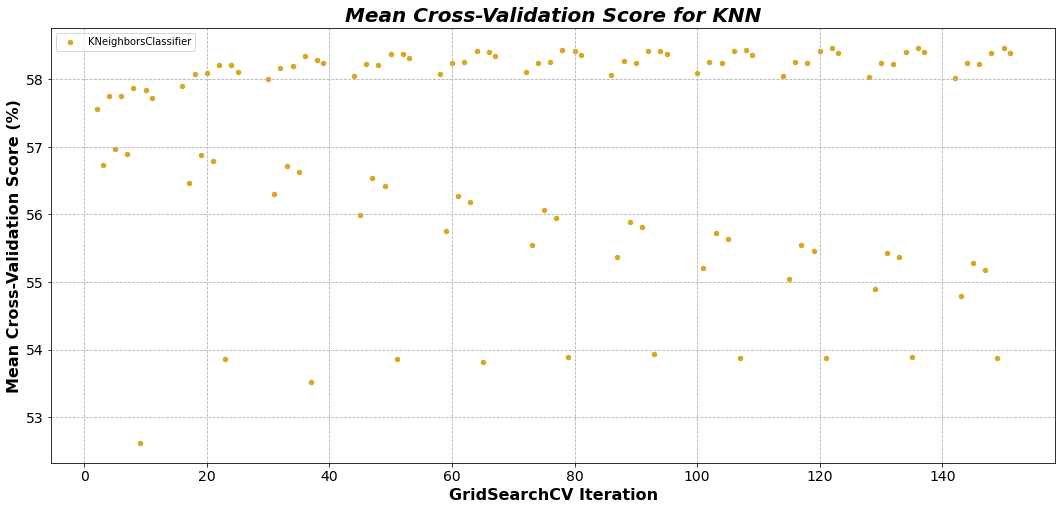

In [59]:
# create a new column with just the model name
results['model_name'] = results['param_model'].apply(lambda x: str(x).split('(')[0])

# plot results sorted by model name and mean test score
# set color based on model name

plotting_results = results.sort_values(by=['model_name', 'mean_test_score']).reset_index(drop=True)

plotting_results['mean_test_score'] = plotting_results['mean_test_score']*100

plt.figure()
for i, m_name in enumerate(plotting_results['model_name'].unique()):
    plotting_results.loc[plotting_results['model_name'] == m_name].plot(
        x='index',
        y='mean_test_score',
        kind='scatter',
        label=m_name,
        color=list(COLOR_DICT.values())[i],
        ax=plt.gca()
    )
plt.xlabel('GridSearchCV Iteration')
plt.ylabel('Mean Cross-Validation Score (%)')
plt.title(
    'Mean Cross-Validation Score for KNN',style='italic'
)

plt.show()

The best KNN model shows a cross-validation score of 58.5%. The parameters are:
* n_neighbors: 1000
* PCA(n_components=6)
* StandardScaler()

Grid search is still selecting the highest number of neighbors possible, however, increasing the number past 1,000 begins to introduce memory limitations. We will choose these as the best parameters for the KNN model. Future work could investigate reducing amount of data being used to train, lowering the `n_jobs` argument of the `GridSearchCV`, or modifying the `dtypes` of the X and y variables to overcome these limits.

We will now make the final predictions on the test sets and evaluate the final accuracy of the model.

In [50]:
# predict X_test with the best model
y_pred = grid.predict(X_test)

# calculate the accuracy_score
acc_score = round(accuracy_score(y_test, y_pred)*100,2)

# calculate mean of y_test
blind_acc = round(np.mean(y_test)*100,2)
# invert if less than 0.5 because the guess would flip at this point
if blind_acc < 50:
    blind_acc = 100 - blind_acc

print('<<<< Blizzard Test Set Scores >>>>')
print(f'A blind guess would have an accuracy of {blind_acc}%')
print(f'The model has accuracy of {acc_score}% on the test set.')
_ = calculate_precision_recall(y_test, y_pred)
display_confusion_matrix(y_test, y_pred, ['Player2 Win', 'Player1 Win'])

<<<< Blizzard Test Set Scores >>>>
A blind guess would have an accuracy of 50.16%
The model has accuracy of 58.43% on the test set.
Precision and Recall for both players


,Player 1,Player 2
Precision (%),58.15,58.72
Recall (%),59.21,57.65


----------------------------------------
	Confusion Matrix (Percentages)


,% Pred Player2 Win,% Pred Player1 Win
% True Player2 Win,28.92,21.24
% True Player1 Win,20.33,29.51


----------------------------------------


Now that we can test the model against the SpawningTool dataset, it would be useful to create a function that performs the data transformations that were performed on the Blizzard dataset.

To compare the two datasets we will need to retrain the model on the Blizzard dataset, without the map column, because the maps in the SpawningTool will not match the maps in the Blizzard dataset.

In [51]:
# function to convert metadata to modeling format
def prepare_metadata_from_model(df):
    
    # list of columns to keep
    keep_columns = [
        'player1_race',
        'player2_race',
        'player1_mmr',
        'player2_mmr',
        'game_length',
        'game_winner'
    ]

    # create a mask where winner = 0 
    mask = df['game_winner'] != 0

    # create the dataframe using the filters
    df = df.loc[mask, keep_columns].copy()

    # rename the game_winner column to winner
    df.rename(columns={'game_winner': 'winner'}, inplace=True)

    # map the player 1 win to 1 and player 2 win to 0
    df['winner'] = df['winner'].map({1: 1, 2: 0})

    # remove any rows with missing values
    df.dropna(inplace=True)

    # set up a list of columns we want to convert to dummy variables
    dummy_columns = [
        'player1_race',
        'player2_race'
    ]

    # set up a list of prefixes we will use for each dummy
    prefix_list = [
        'p1',
        'p2'
    ]

    # convert to dummies
    df = pd.get_dummies(
        df,
        prefix=prefix_list,
        columns=dummy_columns,
        drop_first=False
    )

    # calculate the new feature column
    df['mmr_advantage'] = df['player1_mmr'] - df['player2_mmr']

    # drop the original mmr columns
    df.drop(columns=['player1_mmr', 'player2_mmr'], inplace=True)

    print('The shape of the modeling dataframe is', df.shape)

    return df


In [52]:
testing_df = prepare_metadata_from_model(spawningtool_df)
testing_df.head()

The shape of the modeling dataframe is (6198, 9)


,game_length,winner,p1_Protoss,p1_Terran,p1_Zerg,p2_Protoss,p2_Terran,p2_Zerg,mmr_advantage
2,371,1,0,0,1,0,0,1,520.0
4,502,1,0,0,1,1,0,0,48.0
5,902,1,0,0,1,1,0,0,82.0
6,350,1,0,1,0,1,0,0,728.0
7,514,0,0,0,1,0,1,0,-213.0


In [53]:
# convert the dataframe to X and y np arrays
X_new = testing_df.drop(columns=['winner'])
y_new = testing_df['winner']

# predict the winner using the best model
y_pred_new = grid.predict(X_new)

# calculate the accuracy_score
acc_score = round(accuracy_score(y_new, y_pred_new)*100,2)

# calculate mean of y_new
blind_acc = round(np.mean(y_new)*100,2)
# invert if less than 0.5 because the guess would flip at this point
if blind_acc < 50:
    blind_acc = 100 - blind_acc

print('<<<< SpawningTool Test Set Scores >>>>')
print(f'A blind guess would have an accuracy of {blind_acc}%')
print(f'The model has accuracy of {acc_score}% on the test set.')
_ = calculate_precision_recall(y_new, y_pred_new)
display_confusion_matrix(y_new, y_pred_new, ['Player2 Win', 'Player1 Win'])

<<<< SpawningTool Test Set Scores >>>>
A blind guess would have an accuracy of 51.03%
The model has accuracy of 57.86% on the test set.
Precision and Recall for both players


,Player 1,Player 2
Precision (%),58.72,56.96
Recall (%),58.68,57.00


----------------------------------------
	Confusion Matrix (Percentages)


,% Pred Player2 Win,% Pred Player1 Win
% True Player2 Win,27.91,21.06
% True Player1 Win,21.09,29.95


----------------------------------------


Our new model without maps as variables performs better than the original model, suggesting that map information is not useful for predicting the outcome of the game.

SpawningTool and Blizzard data have accuracies within 1% of each other, suggesting that our model is robust enough to handle new data.

<a style="color:darkviolet"><b>The baseline that we will set for our RNN model to beat then, is 58%</b></a> which is the highest accuracy the KNN model achieved on either test set.

---

---

## Conclusion <a name="section-3"></a>
In this Notebook we had the question: Are there inherent biases at game which would favor one player over the other from the outset? We have attempted to answer these question by:
* Exploring the data contained within the Blizzard Metadata.
* Cleaning and preparing the data for modeling. 
* Creating a KNN model to predict the outcome of the game, achieving an accuracy of 57%.

The answer to the over-arching question for this Notebook is that there are some inherent biases in the game, that we can use to improve our prediction over a blind guess. However, the increase in accuracy is not sufficient enough for any reliable prediction.

In the following Notebook (3) we will create an RNN model which attempts to improve the accuracy of prediction above that achieved by the Metadata model.